In [51]:
import os
import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from keras import models
from keras import layers
from keras.layers import Dropout
import keras

# Preprocessing

In [52]:
df_60 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60.parquet"))
df_120 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_120.parquet"))
df_360 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_360.parquet"))
df_1440 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_1440.parquet"))

In [53]:
df_60_hex_7 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60_hex_7.parquet"))
df_60_hex_8 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60_hex_8.parquet"))

In [54]:
df = df_60

In [55]:
def train_test_split(df, spatial='pickup_census_tract'):
    
    one_hot = pd.get_dummies(df[spatial])
    df = df.drop(spatial,axis = 1)
    df = df.join(one_hot)
    
    df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
    df["trip_start_hour"] = df["trip_start_timestamp"].dt.hour
    df["trip_start_weekday"] = df["trip_start_timestamp"].dt.weekday
    
    df['WEEKDAY'] = np.where((df['trip_start_timestamp']).dt.dayofweek < 5,0,1)
    
    df_train = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 1, 1)) &
              (df["trip_start_timestamp"].dt.date < datetime.date(2013, 7, 1))]
    
    X_train = df_train.drop(['trip_count', "trip_start_timestamp"],axis = 1)
    X_test = df_train[["trip_count"]]
    
    df_test = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 7, 1)) &
             (df["trip_start_timestamp"].dt.date < datetime.date(2013, 12, 1))]
    
    y_train = df_test.drop(['trip_count', "trip_start_timestamp"],axis = 1)
    y_test = df_test[["trip_count"]]
    
    return X_train, y_train, X_test, y_test

In [56]:
X_train, y_train, X_test, y_test = train_test_split(df)

In [57]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (252061, 391)
y_train:  (241637, 391)


We choosed a 50:50 distribution in terms of train and test data, so the first half of the year gets compared with the second one.

In [58]:
X_train = X_train[:len(y_train)]
X_test = X_test[:len(y_test)]

# Neural Network

After preprocessing the already grouped data, afterwards the architecture of the neural network is defined. Beside several hidden layers, we added two dropout layers against overfitting.

In [59]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.40))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.40))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')

    return model

In [60]:
model = build_model()

In [61]:
def plot_results(mae_train_history, mae_val_history, loss_train, loss_val):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle('Neural Network Training Results')

    epochs = range(1, len(mae_train_history) + 1)

    ax1.plot(epochs, mae_train_history, 'bo', label='Training MAE')
    ax1.plot(epochs, mae_val_history, 'b', label='Validation MAE')
    ax1.set_title('Training and validation MAE')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.legend()

    ax2.plot(epochs, loss_train, 'bo', label='Training loss')
    ax2.plot(epochs, loss_val, 'b', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

In [62]:
history = model.fit(X_train, X_test, epochs=50, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/50
1888/1888 [==============================] - 31s 16ms/step - loss: 522.4129 - mae: 11.0579 - val_loss: 349.9316 - val_mae: 8.2736
Epoch 2/50
1888/1888 [==============================] - 30s 16ms/step - loss: 215.8175 - mae: 7.1803 - val_loss: 257.0105 - val_mae: 7.2278
Epoch 3/50
1888/1888 [==============================] - 32s 17ms/step - loss: 186.2222 - mae: 6.7438 - val_loss: 313.2627 - val_mae: 7.7164
Epoch 4/50
1888/1888 [==============================] - 31s 17ms/step - loss: 164.6796 - mae: 6.4301 - val_loss: 240.0259 - val_mae: 6.9409
Epoch 5/50
1888/1888 [==============================] - 28s 15ms/step - loss: 157.9435 - mae: 6.2756 - val_loss: 276.9526 - val_mae: 7.3460
Epoch 6/50
1888/1888 [==============================] - 27s 14ms/step - loss: 152.9135 - mae: 6.2294 - val_loss: 242.1357 - val_mae: 6.9876
Epoch 7/50
1888/1888 [==============================] - 28s 15ms/step - loss: 154.5697 - mae: 6.1781 - val_loss: 234.9933 - val_mae: 7.2144
Epoch 8/50
1888/188

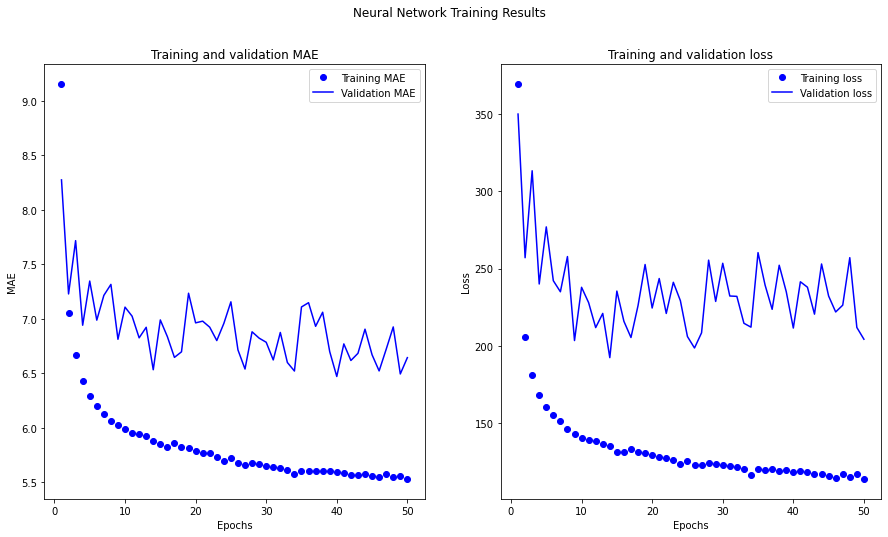

In [63]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

In the first run, we tested the sufficient amount of training epochs to stay as sustainable as possible in terms of computational resources. As we clearly see, the validation mean absolute error doesn't improve anymore after 10 to 15 epochs. So we choose 15 epochs in the training with different features.

# Testing with different temporal resolutions

Below there are several temporal data resolutions used to train the neural network.

## Temporal resolution: 60 Min

In [36]:
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/15
1888/1888 [==============================] - 45s 9ms/step - loss: 535.8128 - mae: 11.0036 - val_loss: 297.0365 - val_mae: 7.6949
Epoch 2/15
1888/1888 [==============================] - 15s 8ms/step - loss: 209.3514 - mae: 7.1067 - val_loss: 296.6268 - val_mae: 7.6673
Epoch 3/15
1888/1888 [==============================] - 16s 8ms/step - loss: 183.5188 - mae: 6.6837 - val_loss: 283.0780 - val_mae: 7.5332
Epoch 4/15
1888/1888 [==============================] - 15s 8ms/step - loss: 171.4944 - mae: 6.4494 - val_loss: 256.6680 - val_mae: 7.0879
Epoch 5/15
1888/1888 [==============================] - 17s 9ms/step - loss: 154.9335 - mae: 6.2470 - val_loss: 240.4755 - val_mae: 7.0960
Epoch 6/15
1888/1888 [==============================] - 15s 8ms/step - loss: 151.6377 - mae: 6.1657 - val_loss: 227.7741 - val_mae: 7.1325
Epoch 7/15
1888/1888 [==============================] - 16s 8ms/step - loss: 146.8279 - mae: 6.0965 - val_loss: 189.4617 - val_mae: 6.6113
Epoch 8/15
1888/1888 [====

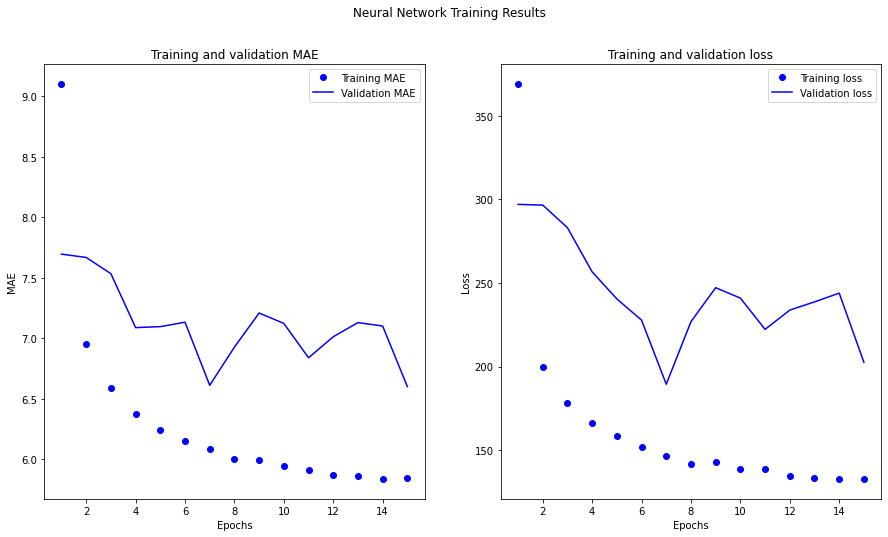

In [37]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

## Temporal resolution: 120 Min

In [12]:
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/15
1149/1149 [==============================] - 41s 7ms/step - loss: 2100.6402 - mae: 21.0488 - val_loss: 1349.9963 - val_mae: 15.0403
Epoch 2/15
1149/1149 [==============================] - 6s 5ms/step - loss: 817.4739 - mae: 12.8561 - val_loss: 980.3521 - val_mae: 13.1586
Epoch 3/15
1149/1149 [==============================] - 7s 6ms/step - loss: 636.6557 - mae: 11.5671 - val_loss: 776.0316 - val_mae: 11.8679
Epoch 4/15
1149/1149 [==============================] - 6s 5ms/step - loss: 599.1133 - mae: 11.1187 - val_loss: 715.7693 - val_mae: 11.3442
Epoch 5/15
1149/1149 [==============================] - 6s 5ms/step - loss: 564.1507 - mae: 10.7750 - val_loss: 780.1761 - val_mae: 11.8325
Epoch 6/15
1149/1149 [==============================] - 6s 6ms/step - loss: 545.2800 - mae: 10.5488 - val_loss: 879.1470 - val_mae: 12.4611
Epoch 7/15
1149/1149 [==============================] - 6s 5ms/step - loss: 513.0136 - mae: 10.4610 - val_loss: 744.9796 - val_mae: 11.5729
Epoch 8/15
1149/1

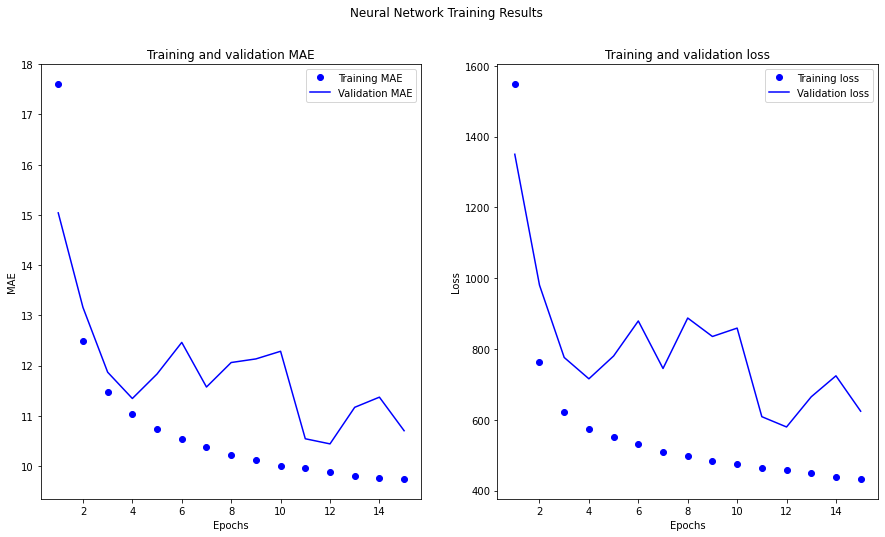

In [17]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

## Temporal resolution: 360 Min

In [26]:
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/15
524/524 [==============================] - 6s 7ms/step - loss: 14839.8378 - mae: 55.3429 - val_loss: 9452.1172 - val_mae: 36.1765
Epoch 2/15
524/524 [==============================] - 3s 6ms/step - loss: 6090.4193 - mae: 31.3874 - val_loss: 6567.8950 - val_mae: 31.8888
Epoch 3/15
524/524 [==============================] - 3s 5ms/step - loss: 3597.4392 - mae: 25.0482 - val_loss: 4397.7134 - val_mae: 27.3520
Epoch 4/15
524/524 [==============================] - 3s 5ms/step - loss: 2952.6016 - mae: 23.7202 - val_loss: 3773.0708 - val_mae: 25.1316
Epoch 5/15
524/524 [==============================] - 3s 6ms/step - loss: 2577.7223 - mae: 22.3598 - val_loss: 4677.3882 - val_mae: 27.4536
Epoch 6/15
524/524 [==============================] - 3s 6ms/step - loss: 2505.2139 - mae: 21.9361 - val_loss: 3829.9375 - val_mae: 25.4344
Epoch 7/15
524/524 [==============================] - 3s 6ms/step - loss: 2620.0918 - mae: 21.5723 - val_loss: 4475.9800 - val_mae: 26.0504
Epoch 8/15
524/524 

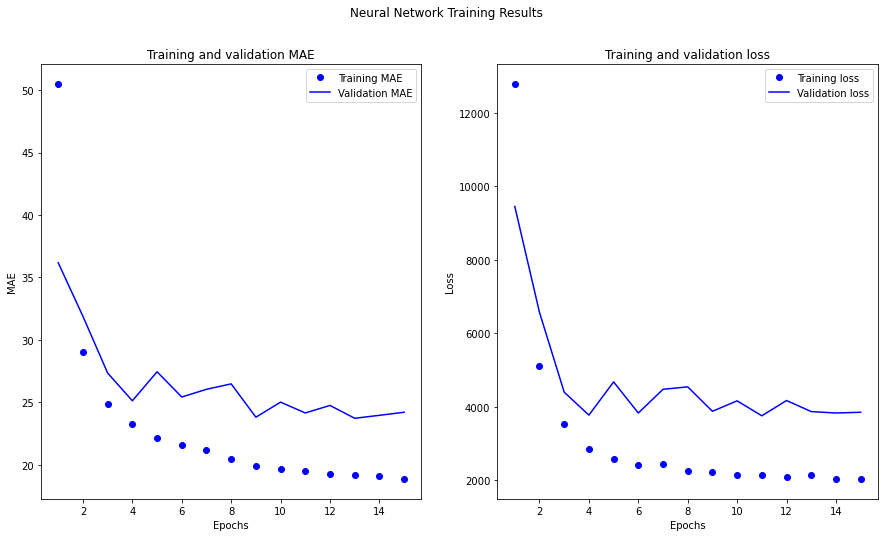

In [28]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

## Temporal resolution: 1440 Min

In [37]:
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/15
200/200 [==============================] - 4s 8ms/step - loss: 71979.0585 - mae: 120.6003 - val_loss: 132823.3125 - val_mae: 146.7828
Epoch 2/15
200/200 [==============================] - 1s 5ms/step - loss: 31466.5971 - mae: 93.1588 - val_loss: 85555.7500 - val_mae: 84.1623
Epoch 3/15
200/200 [==============================] - 1s 5ms/step - loss: 9988.9380 - mae: 43.0679 - val_loss: 82038.7969 - val_mae: 76.8401
Epoch 4/15
200/200 [==============================] - 1s 6ms/step - loss: 7746.1988 - mae: 38.0840 - val_loss: 79433.2344 - val_mae: 71.6734
Epoch 5/15
200/200 [==============================] - 1s 7ms/step - loss: 7722.7413 - mae: 36.5153 - val_loss: 81873.6172 - val_mae: 71.9791
Epoch 6/15
200/200 [==============================] - 2s 8ms/step - loss: 7352.1841 - mae: 35.2440 - val_loss: 81129.2812 - val_mae: 70.0662
Epoch 7/15
200/200 [==============================] - 1s 7ms/step - loss: 7369.2645 - mae: 34.7905 - val_loss: 80455.9844 - val_mae: 68.1299
Epoch 8/

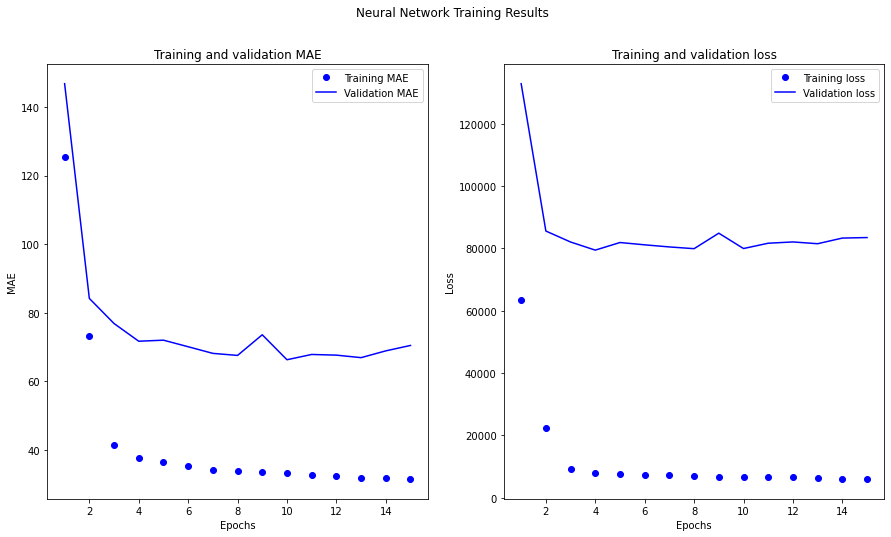

In [38]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

### Results:
The results are getting worse with coarser temporal resolution. The 60 minutes frame provides the best results.

Below the prediction with hexagons as spatial dimension gets tested.

## Testing with H3 Hexagons

## Hexagon resolution 7

In [38]:
X_train, y_train, X_test, y_test = train_test_split(df_60_hex_7, spatial="hex_ID_pickup")

In [39]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (68071, 80)
y_train:  (63554, 80)


In [40]:
X_train = X_train[:len(y_train)]
X_test = X_test[:len(y_test)]

In [47]:
model = build_model()
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Epoch 1/15
497/497 [==============================] - 5s 7ms/step - loss: 13994.4344 - mae: 60.9800 - val_loss: 6219.2104 - val_mae: 37.4743
Epoch 2/15
497/497 [==============================] - 3s 7ms/step - loss: 4765.5431 - mae: 33.4074 - val_loss: 5261.1045 - val_mae: 32.0573
Epoch 3/15
497/497 [==============================] - 5s 11ms/step - loss: 4026.2490 - mae: 29.2362 - val_loss: 4469.9780 - val_mae: 29.6066
Epoch 4/15
497/497 [==============================] - 5s 11ms/step - loss: 3653.9264 - mae: 27.4489 - val_loss: 4143.2100 - val_mae: 27.9085
Epoch 5/15
497/497 [==============================] - 5s 10ms/step - loss: 3549.7988 - mae: 26.7010 - val_loss: 3658.6360 - val_mae: 26.5422
Epoch 6/15
497/497 [==============================] - 5s 11ms/step - loss: 3237.6715 - mae: 25.6582 - val_loss: 3190.5640 - val_mae: 25.2273
Epoch 7/15
497/497 [==============================] - 5s 10ms/step - loss: 3134.2949 - mae: 25.3962 - val_loss: 3953.0698 - val_mae: 27.0525
Epoch 8/15
497

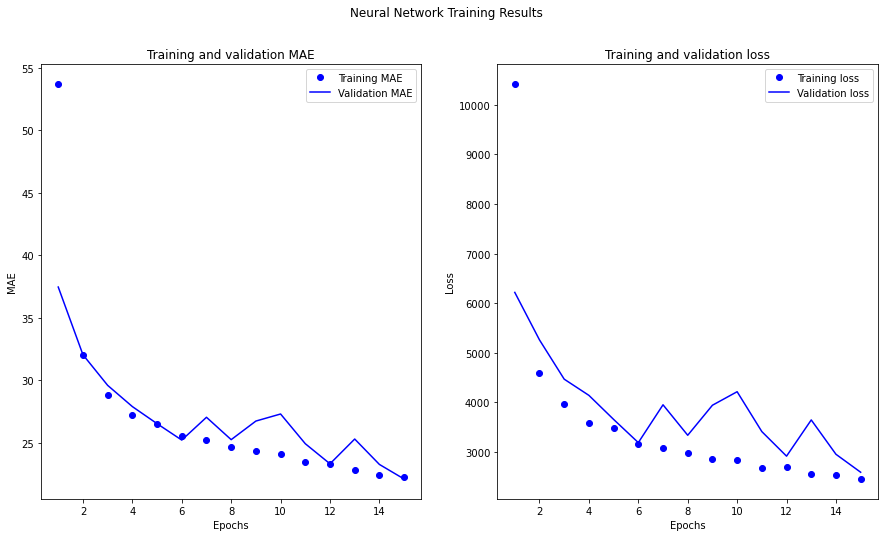

In [48]:
plot_results(mae_train_history, mae_val_history, loss_train, loss_val)

## Hexagon resolution 8

X_train:  (174393, 254)
y_train:  (165858, 254)
Epoch 1/15
1296/1296 [==============================] - 13s 8ms/step - loss: 1143.8384 - mae: 17.8346 - val_loss: 650.3167 - val_mae: 12.6033
Epoch 2/15
1296/1296 [==============================] - 13s 10ms/step - loss: 491.4589 - mae: 11.1050 - val_loss: 594.9648 - val_mae: 11.6823
Epoch 3/15
1296/1296 [==============================] - 10s 7ms/step - loss: 401.9184 - mae: 10.0431 - val_loss: 453.1139 - val_mae: 10.5746
Epoch 4/15
1296/1296 [==============================] - 10s 8ms/step - loss: 364.4130 - mae: 9.5951 - val_loss: 415.8170 - val_mae: 10.2090
Epoch 5/15
1296/1296 [==============================] - 12s 9ms/step - loss: 346.4271 - mae: 9.3357 - val_loss: 457.2124 - val_mae: 10.5622
Epoch 6/15
1296/1296 [==============================] - 9s 7ms/step - loss: 326.8655 - mae: 9.1508 - val_loss: 424.7932 - val_mae: 10.2047
Epoch 7/15
1296/1296 [==============================] - 15s 11ms/step - loss: 316.2009 - mae: 8.9894 - val_l

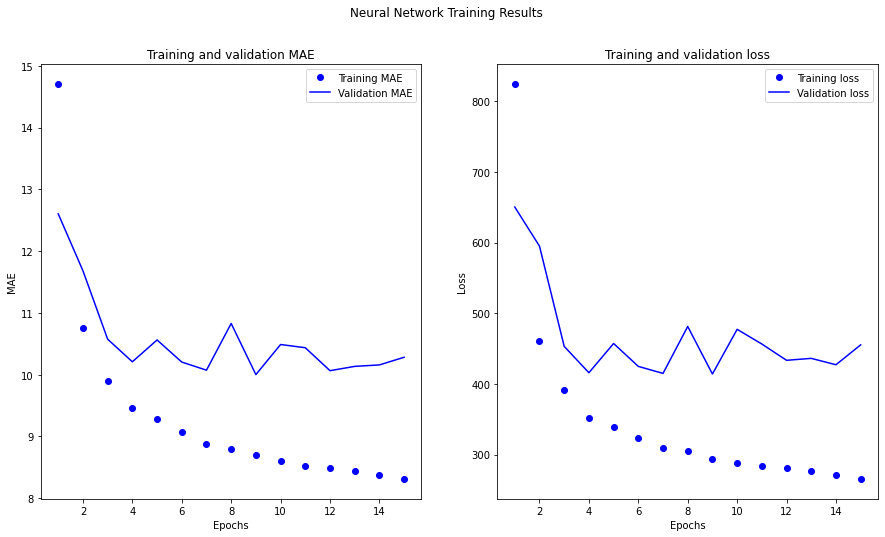

In [50]:
X_train, y_train, X_test, y_test = train_test_split(df_60_hex_8, spatial="hex_ID_pickup")

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train = X_train[:len(y_train)]
X_test = X_test[:len(y_test)]

model = build_model()
history = model.fit(X_train, X_test, epochs=15, batch_size=128, validation_data=(y_train, y_test))
mae_train_history = history.history['mae']
mae_val_history = val_loss = history.history['val_mae']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plot_results(mae_train_history, mae_val_history, loss_train, loss_val)